*Technology transfer for rapid family forest assessments and stewardship planning*

# Generate forest indicators from remotely sensed and climate data

This notebook facilitates the first steps in developing a predictive model to characterize forest conditions using lidar, high-resolution imagery, and field-based inventory data. The follow methods generate a wide variety forest indicators that will be used in predicting forest type maps for a sample area within Clackamas County Oregon.  This is a small subset of our larger study region and is intended for methodological demonstration. 

In [45]:
#load libraries
library(sp)
library(raster)
library(rgdal)
library(rgeos)
library(dismo)
library(maptools)
library(ggmap)

In [2]:
#set plot size
options(repr.plot.width  = 5,
        repr.plot.height = 4)

## Create spatial layer of FIA plots within the area of interest

The Forest Inventory and Analysis (FIA) program of the USDA Forest Service collects inventory data for all forested lands in the U.S., regardless of ownership or availability for harvesting. Data are collected on permanent field plots and consist of a wide variety of attributes, spanning ecological, topographic, and structural characteristics.  Due to privacy requirements specified in the amendments of the FOod Security act of 1985, publicily available FIA plot locations are approximate and can be downloaded via __[FIA Data Mart](https://apps.fs.usda.gov/fia/datamart/datamart_access.html)__. 

The metrics generated for the entire study area will be based on non-fuzzed plot coordinates, made available through a partnership with FIA researchers at the PNW Forest Service Research Station. For demonstration purposes, fuzzed FIA plots are utilized for this sample case. The PLOT table of the Oregon FIA inventory database was exported as a text file is used to plot the locations of forested plots in Clackamas County. 

In [89]:
#read in fia plot data text filea
fia <- read.csv("./Data/FIA/FIA_OregonStatePlots.csv", header=TRUE, sep=",")

In [90]:
#plot points using lat/lon coordinates
pts <- SpatialPointsDataFrame(fia[,c("LON", "LAT")], fia[c(5:9, 20:21)])
pts_m <- data.frame(fia[c(5:9,20:21)])

In [91]:
#print first five rows
head(pts,n=5)

INVYR,STATECD,UNITCD,COUNTYCD,PLOT,LAT,LON
2011,41,2,11,60402,43.04,-123.90
2005,41,4,59,81694,45.06,-118.76
2005,41,4,59,67643,45.08,-118.58
2005,41,4,59,95355,45.19,-119.12
2005,41,4,59,50581,45.23,-118.77


In [92]:
#set coordinate system
crs(pts) <- NA
crs(pts) <- CRS("+proj=longlat +datum=NAD83")

In [93]:
#reproject to NAD83_2011 Oregon Lambert
utm <- "+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
nad83 <- "+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=399999.9999984 +y_0=0 +ellps=GRS80 +units=ft +no_defs"
pts <- spTransform(pts, nad83)

## Create plot polygons

In this step we remove plots that fall outside of our study region, plots that were inventoried after the lidar acquistion, and plots that had some time of disturbance event occur since the inventory date.  We also add a buffer around the plot center to match the plot dimensions and create a hexagonal grid within each buffer for imputation purposes. 

### Remove plots that fall outside the study area.

In [94]:
#read in study area polygon
#reproject to NAD83_2011 Oregon Lambert
area_o <- readOGR("./Data/Misc/Study_Area.shp")
area <- spTransform(area_o, nad83)
area_m <-spTransform(area_o, "+proj=longlat +datum=NAD83")

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\sloreno\ForestMapping\Data\Misc\Study_Area.shp", layer: "Study_Area"
with 6 features
It has 4 fields
Integer64 fields read as strings:  Year Acres 


In [95]:
area_df <- fortify(area_m)


Regions defined for each Polygons


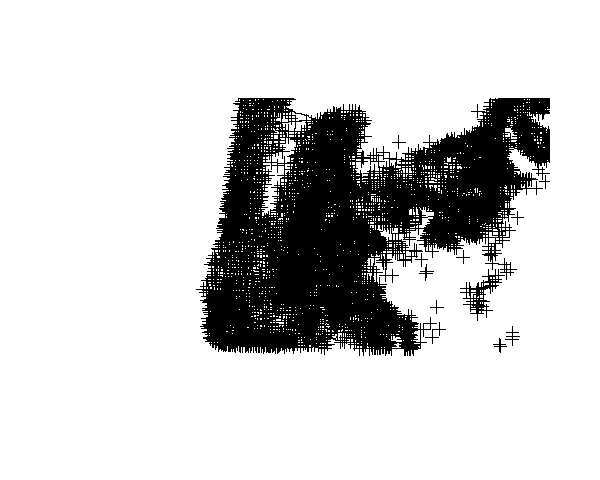

In [96]:
#plot spatial layers
plot(area)
plot(pts, add=T)

In [97]:
#clip points to study area and attach lidar acquistion year
pts_clip_lidar <- intersect(pts, area)
names(pts_clip_lidar)[10]<-"lidarYear"
pts_clip_lidar$lidarYear <-as.numeric(as.character(pts_clip_lidar$lidarYear))
head(pts_clip_lidar)

,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,LAT,LON,Project,PROGRAM,lidarYear,Acres
81,2005,41,3,35,56137,42.39,-122.07,Klamath,OLC,2010,1280462
82,2005,41,3,35,85209,42.44,-121.56,Sprague River,Klamath Tribes,2004,337155
85,2005,41,3,35,67025,42.54,-122.09,Klamath,OLC,2010,1280462
90,2005,41,3,35,99771,42.63,-121.29,Klamath,OLC,2010,1280462
91,2005,41,3,35,69709,42.70,-122.10,Klamath,OLC,2010,1280462
92,2005,41,3,35,72880,42.65,-120.93,Klamath,OLC,2010,1280462


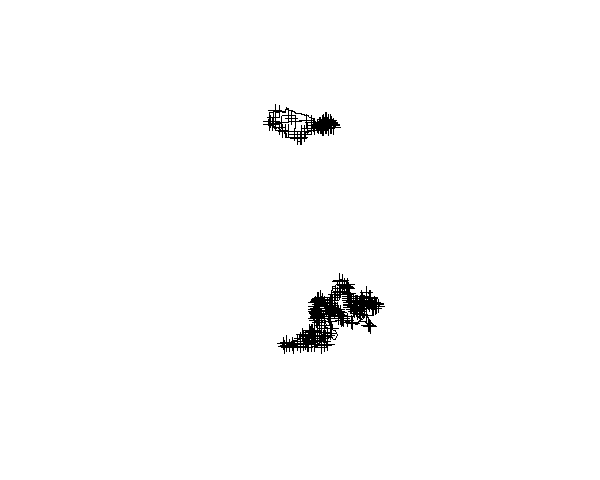

In [98]:
#plot spatial layers
plot(area)
plot(pts_clip_lidar, add=T)

### Delete plots that were inventoried *after* the lidar acquisition date

In [128]:
#delete plots with inventory year > lidar acquistion year
pts_clip_lidar_filter <- pts_clip_lidar[pts_clip_lidar$lidarYear > pts_clip_lidar$INVYR, ]
paste(nrow(pts_clip_lidar_filter), "plots remain after filter")
head(pts_clip_lidar_filter, n=1)

[1] "318 plots remain after filter"

,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,LAT,LON,Project,PROGRAM,lidarYear,Acres
81,2005,41,3,35,56137,42.39,-122.07,Klamath,OLC,2010,1280462


### Delete duplicate plots - remove earliest inventory instance

In [129]:
plot_year <- aggregate(INVYR ~ PLOT, pts_clip_lidar_filter, max)
paste(nrow(plot_year), "plots remain after filter")
head(plot_year, n=1)

[1] "274 plots remain after filter"

PLOT,INVYR
50077,2005


In [130]:
pts_clip_lidar_filter <- merge(pts_clip_lidar_filter, plot_year, by.x=c("INVYR", "PLOT"), by.y=c("INVYR", "PLOT"), all.x = FALSE)
head(pts_clip_lidar_filter, n=1)
paste(nrow(pts_clip_lidar_filter), "plots remain after filter")

,INVYR,PLOT,STATECD,UNITCD,COUNTYCD,LAT,LON,Project,PROGRAM,lidarYear,Acres
82,2005,56137,41,3,35,42.39,-122.07,Klamath,OLC,2010,1280462


[1] "274 plots remain after filter"

In [131]:
class(pts_clip_lidar_filter)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

### Add a buffer of 180 ft to each point center

In [132]:
#add buffer of 180 feet to points 
pts_clip_lidar_filter_buff <- gBuffer(pts_clip_lidar_filter, width=180, byid=TRUE)

In [133]:
pts_clip_lidar_filter_buff <- SpatialPolygonsDataFrame( pts_clip_lidar_filter_buff, data=pts_clip_lidar_filter_buff@data )
head(pts_clip_lidar_filter_buff, n=1)

,INVYR,PLOT,STATECD,UNITCD,COUNTYCD,LAT,LON,Project,PROGRAM,lidarYear,Acres
82,2005,56137,41,3,35,42.39,-122.07,Klamath,OLC,2010,1280462


In [134]:
print(nrow(pts_clip_lidar_filter_buff))

[1] 274


### Remove plots that have experienced a disturbance event since inventory

Disturbance data is sourced from the __[Global Forest Watch](http://data.globalforestwatch.org/)__ and is a product of the alogrithms that capture, label, and map land cover change.

In [135]:
#load landtrendr distrubance (year of disturbance) raster
disturb <- raster("./Data/Landtrendr/ForestLoss_year.tif")

In [18]:
#project raster to nad83
beginCluster(4) 
disturb<- projectRaster(disturb, crs=nad83)
endCluster()

Loading required namespace: parallel
Using cluster with 4 nodes


In [136]:
#extract max disturbance year for each plot polygon
beginCluster(4) 
pts_clip_lidar_filter_buff_disturb <- extract(disturb, pts_clip_lidar_filter_buff, fun=max, df=TRUE)
endCluster()

Warning message in .local(x, y, ...):
"Transforming SpatialPolygons to the CRS of the Raster"Using cluster with 4 nodes


In [137]:
#add plot id
pts_clip_lidar_filter_buff_disturb$plot <- pts_clip_lidar_filter_buff$PLOT
#clean up column names
names(pts_clip_lidar_filter_buff_disturb) <- c('ID', 'distYear', 'plot')
#convert NA distYear values to 0
pts_clip_lidar_filter_buff_disturb$distYear[is.na(pts_clip_lidar_filter_buff_disturb$distYear)] <- 0 
print(nrow(pts_clip_lidar_filter_buff_disturb))
head(pts_clip_lidar_filter_buff_disturb, n=5)

[1] 274


ID,distYear,plot
1,0,56137
2,0,67025
3,0,99771
4,0,69709
5,0,72880


In [138]:
#merge back with rest of dataframe
pts_clip_lidar_filter_buff_disturb <- merge(pts_clip_lidar_filter_buff, pts_clip_lidar_filter_buff_disturb, by.x='PLOT', by.y="plot")
#print header
head(pts_clip_lidar_filter_buff_disturb)

,PLOT,INVYR,STATECD,UNITCD,COUNTYCD,LAT,LON,Project,PROGRAM,lidarYear,Acres,ID,distYear
30,56137,2005,41,3,35,42.39,-122.07,Klamath,OLC,2010,1280462,1,0
96,67025,2005,41,3,35,42.54,-122.09,Klamath,OLC,2010,1280462,2,0
273,99771,2005,41,3,35,42.63,-121.29,Klamath,OLC,2010,1280462,3,0
110,69709,2005,41,3,35,42.70,-122.10,Klamath,OLC,2010,1280462,4,0
125,72880,2005,41,3,35,42.65,-120.93,Klamath,OLC,2010,1280462,5,0
71,63792,2005,41,3,35,42.75,-121.46,Klamath,OLC,2010,1280462,6,0


In [139]:
#delete plots with disturbance > FIA inv year
pts_clip_lidar_filter_buff_disturb_filter <- pts_clip_lidar_filter_buff_disturb[pts_clip_lidar_filter_buff_disturb$distYear < pts_clip_lidar_filter_buff_disturb$INVYR, ]

### Create hexagon grid within each FIA buffered plot

Make_grid function sourced from __[Matt Strimas-Mackey](http://strimas.com/spatial/hexagonal-grids/)__

In [140]:
make_grid <- function(x, cell_diameter, cell_area, clip = FALSE) {
  if (missing(cell_diameter)) {
    if (missing(cell_area)) {
      stop("Must provide cell_diameter or cell_area")
    } else {
      cell_diameter <- sqrt(2 * cell_area / sqrt(3))
    }
  }
  ext <- as(extent(x) + cell_diameter, "SpatialPolygons")
  projection(ext) <- projection(x)
  # generate array of hexagon centers
  g <- spsample(ext, type = "hexagonal", cellsize = cell_diameter, 
                offset = c(0.5, 0.5))
  # convert center points to hexagons
  g <- HexPoints2SpatialPolygons(g, dx = cell_diameter)
  # clip to boundary of study area
  if (clip) {
    g <- gIntersection(g, x, byid = TRUE)
  } else {
    g <- g[x, ]
  }
  # clean up feature IDs
  row.names(g) <- as.character(1:length(g))
  return(g)
}

In [141]:
#make grid - 1/4 acre hexagons
fia_grid <- make_grid(pts_clip_lidar_filter_buff_disturb_filter, cell_area = 10890, clip = FALSE)

ERROR: Error: memory exhausted (limit reached?)


In [46]:
#intersect with plot buffer layer to get attributes
fia_grid <- intersect(fia_grid, pts_clip_lidar_filter_buff_disturb_filter)

In [73]:
#add unique id field to fia_grid layer
fia_grid$hex_id <- 1:nrow(fia_grid)

### Export Data

In [142]:
#export csv of plot ids, lidar years, and disturbance years to be used to create FVS input
write.csv(pts_clip_lidar_filter_buff_disturb_filter, "./FVS/FVS_input.csv",  row.names=FALSE)

In [143]:
#export shapefile of plots (w/buffer)
writeOGR(obj=pts_clip_lidar_filter_buff_disturb_filter, dsn="./Data/FIA", layer="FIA_plots", driver="ESRI Shapefile",
        overwrite_layer=TRUE)
#export shapefile of plots with hexes
#writeOGR(obj=fia_grid, dsn="./Data/FIA", layer="FIA_plots_hex", driver="ESRI Shapefile", overwrite_layer=TRUE)

## Calculate predictor variables from LANDSAT remotely sensed imagery

For over 40 years, a series of __[LANDSAT](https://earthexplorer.usgs.gov/)__ satellites have recorded a temporal record of multispectral data of the Earth’s surface at a global level. At a moderate resolution, 30m x 30m, Landsat imagery is a valuable resource for regional forestry applications.  It is expected that a substantial effort will be required to gather suitable cloud-free LANDSAT images for a given year and to follow procedures such as histogram equalization to normalize images across years. However, Analysis Ready Data (ARD) -- imagery processed to significantly reduce the magnitude of data processing by users, will be utilized whenever possible. 

Remotely sensed imagery will be summarized within areal units defined by a hexagonal tessellation overlaid on the FIA plots. To respect USFS concerns to conceal FIA plot locations, no data layers with a resolution finer than this tessellation will be taken off-site. This hexagonal tessellation will also be reproduced across the entire LiDAR footprints, and these hexagons will be the level at which forest type predictions are made. 

In [48]:
#create a list of all the landsat bands from landsat directory
landsat_names <-  Sys.glob(file.path("./Data/Landsat/sampleArea", "*.tif"))
images <- sapply(landsat_names, raster) 

In [49]:
#create raster brick from .tif files
ls8<-stack(images)

In [50]:
## tasseled cap coefficients
refB = c(0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872) 
refG = c(-0.2941, -0.243, -0.5424, 0.7276, -0.0713,-0.1608)
refW = c(0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559)

In [51]:
#function to calculate tasseled cap and band ratio metrics 'calc_landsMets'
calc_landMets <- function(r) {
    b <- r[[2]] * refB[1] + r[[3]] * refB[2] + r[[4]] * refB[3] + r[[5]] * refB[4] + r[[6]] * refB[5] + r[[7]] * refB[6]
    g <- r[[2]] * refG[1] + r[[3]] * refG[2] + r[[4]] * refG[3] + r[[5]] * refG[4] + r[[6]] * refG[5] + r[[7]] * refG[6]
    w <- r[[2]] * refW[1] + r[[3]] * refW[2] + r[[4]] * refW[3] + r[[5]] * refW[4] + r[[6]] * refW[5] + r[[7]] * refW[6]
    ndvi <- (r[[5]] - r[[4]])/(r[[5]] + r[[4]])
    gndvi <- (r[[5]] - r[[3]])/(r[[5]] + r[[3]])
    nbr <- (r[[5]] - r[[7]])/(r[[5]] + r[[7]])
    g_ratio <- r[[5]] - r[[3]]
    b1 <- r[[1]]
    b2 <- r[[2]]
    b3 <- r[[3]]
    b4 <- r[[4]]
    b5 <- r[[5]]
    b7 <- r[[7]]
    l_mets <- stack(b, g, w, ndvi, gndvi, nbr, g_ratio, b1, b2, b3, b4, b5, b7)
    names(l_mets) <- c('brightness', 'greenness', 'wetness', 'ndvi', 'gndvi', 'nbr', 'g_ratio', 'b1', 'b2', 'b3', 'b4', 'b5', 'b7')  
return(l_mets)
}

In [52]:
#calculate metrics using 'calc_landsMets' function on landsat stack
l_mets <- calc_landMets(ls8)

In [ ]:
beginCluster(4)
l_mets<- projectRaster(l_mets, crs=nad83)
endCluster()

Using cluster with 4 nodes


In [84]:
#calculate mean zonal statistics for tasseled cap and indices for each plot hexagon
ext_mets <- extract(l_mets, fia_grid, fun = mean, na.rm = T, df=T)

Using cluster with 4 nodes


In [89]:
ext_mets <- merge(fia_grid, ext_mets, by.x='hex_id', by.y="ID")
head(ext_mets)

hex_id,PLOT,INVYR,STATECD,UNITCD,COUNTYCD,lidarYear,ID,distYear,brightness,...,ndvi,gndvi,nbr,g_ratio,b1,b2,b3,b4,b5,b7
1,76297,2010,41,0,5,2014,3,0,3173.539,...,0.7960520,0.6763965,0.7212062,2618.572,1032.874,789.6469,625.3897,367.9398,3243.961,525.7991
2,76297,2010,41,0,5,2014,3,0,3732.965,...,0.7108046,0.6215294,0.6022540,2579.660,1072.725,860.5886,785.6359,569.7339,3365.296,838.8910
3,76297,2010,41,0,5,2014,3,0,3171.986,...,0.8071797,0.6908115,0.7437822,2722.041,1032.325,788.6950,607.7817,354.4156,3329.823,489.0071
4,76297,2010,41,0,5,2014,3,0,3153.335,...,0.7966665,0.6784129,0.7268147,2618.748,1034.515,792.9394,619.3289,365.8104,3238.077,513.8638
5,76297,2010,41,0,5,2014,3,0,2871.043,...,0.7884614,0.6701534,0.7390763,2378.499,1031.097,786.9896,581.2408,348.4653,2959.740,447.0334
6,76297,2010,41,0,5,2014,3,0,3330.206,...,0.7918375,0.6746353,0.7108012,2724.389,1041.384,802.5393,656.9908,392.8430,3381.379,572.6086


In [90]:
#write landsat variables to csv
write.csv(ext_mets, "./Classification/land_mets.csv",  row.names=FALSE)

## Create predictor variables from Climate Data

To estimate climate attributes for our study area, we will be using __[ClimateWNA](https://sites.ualberta.ca/~ahamann/data/climatewna.html)__ software. This application provides historical and projected climate data for North America, including monthly, seasonal, and annual attributes, as well as derived metrics such as Growing Degree Days, Potential Evapotranspiration, etc. that are useful for vegetation modeling. 

A ClimateWNA executable file is included within this repository. In the next couple steps, we create the input needed to derive our selected attributes.  Once that input table is created, the ClimateWNA executable is run and will pop up in an external window.  Set the created text file as input and run the application to create an additional text file containing attributes for our study area. 

In [22]:
#create csv for climateWNA application
head(fia, n=1)

CN,SRV_CN,CTY_CN,PREV_PLT_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,PLOT_STATUS_CD,...,NF_SAMPLING_STATUS_CD,NF_PLOT_STATUS_CD,NF_PLOT_NONSAMPLE_REASN_CD,P2VEG_SAMPLING_STATUS_CD,P2VEG_SAMPLING_LEVEL_DETAIL_CD,INVASIVE_SAMPLING_STATUS_CD,INVASIVE_SPECIMEN_RULE_CD,DESIGNCD_P2A,MANUAL_DB,SUBPANEL
1.28607e+13,1.277713e+13,102010497,NA,2005,41,0,5,93124,1,...,NA,NA,NA,NA,NA,NA,NA,NA,7,2


In [92]:
fia_vars <- c("PLOT", "LON", "LAT", "ELEV")
fia_coords <- fia[fia_vars]

In [93]:
fia_coords <- merge(fia_coords, pts_clip_lidar_filter_buff_disturb_filter)

In [94]:
fia_vars2 <- c("PLOT", "STATECD", "LAT", "LON", "ELEV")
fia_coords <- fia_coords[fia_vars2]
names(fia_coords) <- c("ID1", "ID2", "lat", "lon", 'el')

In [95]:
write.csv(fia_coords, "./Data/Climate/climate_input.csv",  row.names=FALSE)

This next cell will open the ClimateWNA application. Select the 'climate_input.csv" created in the last cell as input.  Save the output as 'climate_input_year_2014Y.csv". 

In [12]:
#Open climateWNA application
wd<-getwd()
system(paste(file.path(wd, "Data/Climate/ClimateWNA_v5.51.exe")))

#select climate_input.csv as input
#output file to data/climate

In [97]:
#read in output created in last step from CLIMATEWNA
climate <- read.csv("./Data/Climate/climate_input_year_2014Y.csv", header=TRUE, sep=",")
head(climate)

ID1,ID2,Latitude,Longitude,Elevation,MAT,MWMT,MCMT,TD,MAP,...,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,MAR,RH
60634,41,45.40564,-122.4063,300,11.7,20.1,3.8,16.3,1791,...,86,327,241,50,-16.4,37.8,874,311,-9999,67
65759,41,45.45600,-122.4703,500,10.7,19.3,2.9,16.4,2128,...,102,319,218,91,-18.5,37.4,859,309,-9999,67
74773,41,45.44719,-122.3982,700,10.7,19.1,3.1,15.9,1847,...,110,317,208,74,-18.6,38.1,873,334,-9999,65
76297,41,45.40246,-122.4724,100,12.8,21.4,5.0,16.4,1368,...,69,335,266,23,-14.0,39.0,912,411,-9999,67


In [98]:
#keep variables we are intrested in
climate_vars <- c("ID1", "ID2", "MAT", "MAP", "MWMT", "MSP", "MCMT", "PAS", "DD5", "Eref", "NFFD", "CMD")
climate_mets <- climate[climate_vars]
#rename ID1 and ID2 fields
names(climate_mets)[1]<-"plot"
names(climate_mets)[2]<-"state"
#write to csv file
write.csv(climate_mets, "./Classification/climate_mets.csv",  row.names=FALSE)